In [3]:
import numpy as np
import tensorflow as tf
import helpful_functions as hf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ---only for cluster--- #
import tensorflow as tf

phys_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(phys_devices[0], True)
except IndexError:
    pass

In [4]:
# -----encoder output 5x5x16----- #
#encoder
encoder_inputs = keras.Input(shape=(32, 32, 1), name="img_input")
x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x  = layers.Conv2D(16, 3, activation="relu")(block_3_output)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_outputs = layers.MaxPooling2D(2)(x)

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
encoder.summary()

#decoder
decoder_inputs = keras.Input(shape=(5, 5, 16), name="decoder_input")
x = layers.UpSampling2D(2)(decoder_inputs)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
block_4_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_5_output = layers.add([x, block_4_output])

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.UpSampling2D(2)(block_6_output)
x = layers.Conv2DTranspose(8, 3, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

autoencoder_input1 = keras.Input(shape=(32, 32, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(32, 32, 1), name="input_img2")
encoded_img1 = encoder(autoencoder_input1)
encoded_img2 = encoder(autoencoder_input2)
encoded_img3 = layers.add((encoded_img1,encoded_img2))
decoded_img1 = decoder(encoded_img1)
decoded_img2 = decoder(encoded_img2)
decoded_img3 = decoder(encoded_img3)
autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2], outputs=[decoded_img1,decoded_img2,decoded_img3], name="autoencoder")
autoencoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 30, 8)    80          ['img_input[0][0]']              
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 16)   1168        ['conv2d_8[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 16)  0           ['conv2d_9[0][0]']               
                                                                                            

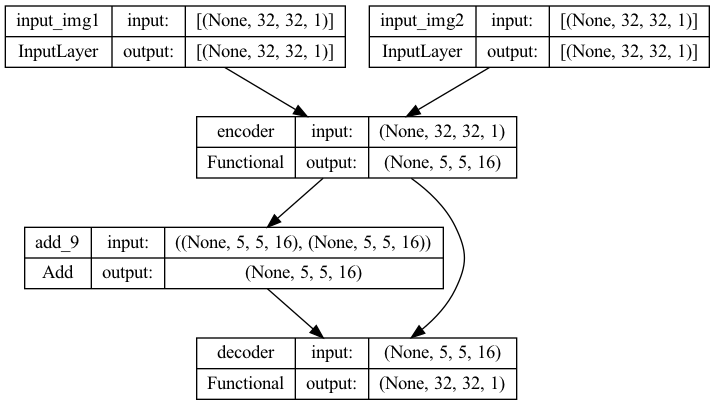

In [7]:
keras.utils.plot_model(encoder, "mini_resnet.png", show_shapes=True)
keras.utils.plot_model(decoder, "mini_resnet2.png", show_shapes=True)
keras.utils.plot_model(autoencoder, "mini_resnet3.png", show_shapes=True)

In [3]:
# load data_set
data_set = hf.load_dataset_npz('data_set/10000samples_3_8_ratio03_shuffle.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_bgnoise(03005).npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :2]
y_train = data_set[:8000]
x_test = data_set[8000:, :2]
y_test = data_set[8000:]

In [4]:
# train the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

monitor = EarlyStopping(monitor='decoder_2_loss', min_delta=1e-5, patience=5,
                        verbose=1, mode='auto', restore_best_weights=True)
history = autoencoder.fit([x_train[:,0],x_train[:,1]], [y_train[:,0],y_train[:,1],y_train[:,2]], epochs=150,
                          validation_data=((x_test[:,0],x_test[:,1]), (y_test[:, 0],y_test[:, 1],y_test[:, 2])),
                          shuffle=True, batch_size=400, callbacks=[monitor])

# save the trained model
# autoencoder.save('saved_model/2Inputs_(5x5x16)2')
encoder.save('saved_model/encoder_5x5x16_2')
decoder.save('saved_model/decoder_5x5x16_2')

Epoch 1/150


2023-01-25 16:24:59.174683: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-25 16:24:59.742397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.1181 - decoder_loss: 0.0290 - decoder_1_loss: 0.0289 - decoder_2_loss: 0.0601

2023-01-25 16:25:02.659059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 132ms/step - loss: 0.1181 - decoder_loss: 0.0290 - decoder_1_loss: 0.0289 - decoder_2_loss: 0.0601 - val_loss: 0.0605 - val_decoder_loss: 0.0147 - val_decoder_1_loss: 0.0148 - val_decoder_2_loss: 0.0309
Epoch 2/150
20/20 [==============================] - 2s 104ms/step - loss: 0.0513 - decoder_loss: 0.0127 - decoder_1_loss: 0.0127 - decoder_2_loss: 0.0259 - val_loss: 0.0401 - val_decoder_loss: 0.0096 - val_decoder_1_loss: 0.0097 - val_decoder_2_loss: 0.0208
Epoch 3/150
20/20 [==============================] - 2s 104ms/step - loss: 0.0345 - decoder_loss: 0.0085 - decoder_1_loss: 0.0084 - decoder_2_loss: 0.0176 - val_loss: 0.0277 - val_decoder_loss: 0.0066 - val_decoder_1_loss: 0.0067 - val_decoder_2_loss: 0.0145
Epoch 4/150
20/20 [==============================] - 2s 105ms/step - loss: 0.0236 - decoder_loss: 0.0056 - decoder_1_loss: 0.0056 - decoder_2_loss: 0.0124 - val_loss: 0.0196 - val_decoder_loss: 0.0046 - val_decoder_1_loss: 0.0046 - val

INFO:tensorflow:Assets written to: saved_model/encoder_5x5x16_2/assets


INFO:tensorflow:Assets written to: saved_model/encoder_5x5x16_2/assets


INFO:tensorflow:Assets written to: saved_model/decoder_5x5x16_2/assets


INFO:tensorflow:Assets written to: saved_model/decoder_5x5x16_2/assets


In [5]:
# make predictions
predictions = autoencoder.predict([x_test[:,0],x_test[:,1]])
np.shape(predictions)

2023-01-25 16:28:55.529251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 13ms/step


(3, 2000, 32, 32, 1)

In [ ]:
# new data_set
data_set = hf.load_dataset_npz('data_set/10000samples_3_8_ratio05.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_bgnoise(03005).npz')
x_train = data_set[:8000, :2]
y_train = data_set[:8000]
x_test = data_set[8000:, :2]
y_test = data_set[8000:]

predictions = autoencoder.predict([x_test[0:200,0],x_test[0:200,1]])

(-0.5, 31.5, -0.5, 31.5)

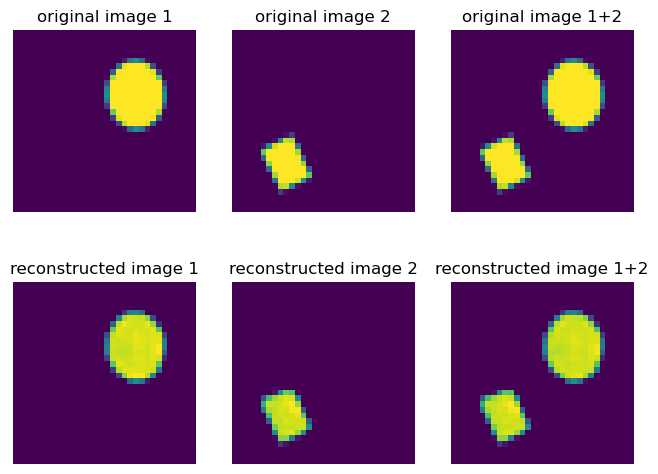

In [16]:
# compare the predictions with original images
num = 173
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
ax[0][0].imshow(x_test[num-1,0], origin='lower')
ax[0][0].set_title('original image 1')
ax[0][0].axis('off')
ax[0][1].imshow(x_test[num-1,1], origin='lower')
ax[0][1].set_title('original image 2')
ax[0][1].axis('off')
ax[0][2].imshow(data_set[num-1+8000, 2], origin='lower')
ax[0][2].set_title('original image 1+2')
ax[0][2].axis('off')
ax[1][0].imshow(predictions[0][num-1], origin='lower')
ax[1][0].set_title('reconstructed image 1')
ax[1][0].axis('off')
ax[1][1].imshow(predictions[1][num-1], origin='lower')
ax[1][1].set_title('reconstructed image 2')
ax[1][1].axis('off')
ax[1][2].imshow(predictions[2][num-1], origin='lower')
ax[1][2].set_title('reconstructed image 1+2')
ax[1][2].axis('off')
#plt.savefig("output/sample183_3316.png")

In [ ]:
import pandas as pd

history_df = pd.DataFrame(history.history)

with open('output/trainHistory.csv', 'wb') as file:
    history_df.to_csv(file)

In [14]:
mse = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse(y_test[:,2], predictions[2]).numpy()}")
ssim = tf.image.ssim(y_test[:,2], predictions[2],max_val=1.0)
ssim_mean = np.mean(ssim)
print(f"ssim is for sample {193}: {ssim[193].numpy()}")
print(f"mean of ssim is: {ssim_mean}")

mse is: 0.0011927693849429488
ssim is for sample 193: 0.9884713888168335
mean of ssim is: 0.9862358570098877


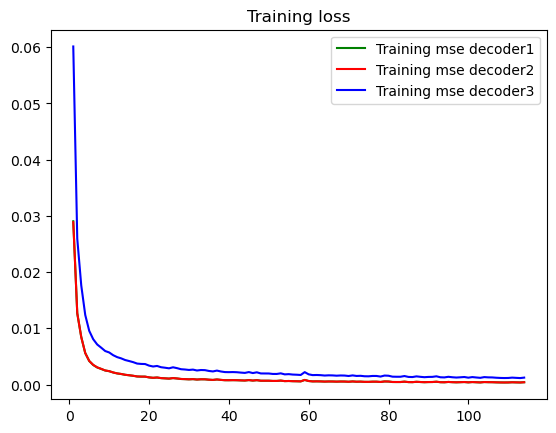

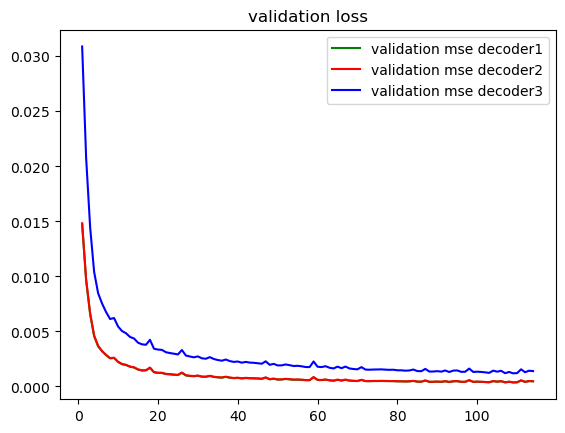

<Figure size 640x480 with 0 Axes>

In [17]:
# plot train losses and validatin losses
mse3 = history.history['decoder_2_loss']
mse1 = history.history['decoder_loss']
mse2 = history.history['decoder_1_loss']
var_mse3 = history.history['val_decoder_2_loss']
var_mse1 = history.history['val_decoder_loss']
var_mse2 = history.history['val_decoder_1_loss']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(mse2) + 1)

plt.plot(epochs, mse1, 'g', label='Training mse decoder1')
plt.plot(epochs, mse2, 'r', label='Training mse decoder2')
plt.plot(epochs, mse3, 'b', label='Training mse decoder3')
#plt.plot(epochs, var_mse3, 'r', label='validation mse decoder3')

plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, var_mse1, 'g', label='validation mse decoder1')
plt.plot(epochs, var_mse2, 'r', label='validation mse decoder2')
plt.plot(epochs, var_mse3, 'b', label='validation mse decoder3')
#plt.plot(epochs, loss, 'g', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validation loss')
plt.legend()
plt.figure()
plt.show()

63/63 [==============================] - 1s 10ms/step
mse is: 0.002710335422307253
ssim is for sample 193: 0.9890601634979248
mean of ssim is: 0.9660110473632812


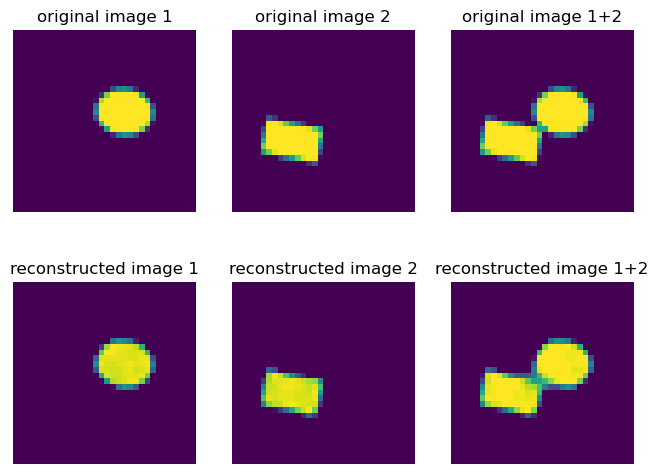

In [15]:
# load new data_set
data_set2 = hf.load_dataset_npz('data_set/10000samples_3_8_ratio05.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_bgnoise(03005).npz')
data_set2 = data_set2.astype('float32')
x_train2 = data_set2[:8000, :2]
y_train2 = data_set2[:8000]
x_test2 = data_set2[8000:, :2]
y_test2 = data_set2[8000:]

predictions2 = autoencoder.predict([x_test2[:,0],x_test2[:,1]])

# compare the predictions with original images
num = 90
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
ax[0][0].imshow(x_test2[num-1,0], origin='lower')
ax[0][0].set_title('original image 1')
ax[0][0].axis('off')
ax[0][1].imshow(x_test2[num-1,1], origin='lower')
ax[0][1].set_title('original image 2')
ax[0][1].axis('off')
ax[0][2].imshow(data_set2[num-1+8000, 2], origin='lower',vmin=0, vmax=1)
ax[0][2].set_title('original image 1+2')
ax[0][2].axis('off')
ax[1][0].imshow(predictions2[0][num-1], origin='lower')
ax[1][0].set_title('reconstructed image 1')
ax[1][0].axis('off')
ax[1][1].imshow(predictions2[1][num-1], origin='lower')
ax[1][1].set_title('reconstructed image 2')
ax[1][1].axis('off')
ax[1][2].imshow(predictions2[2][num-1], origin='lower',vmin=0, vmax=1)
ax[1][2].set_title('reconstructed image 1+2')
ax[1][2].axis('off')

mse2 = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse2(y_test2[:,2], predictions2[2]).numpy()}")
ssim2 = tf.image.ssim(y_test2[:,2], predictions2[2],max_val=1.0)
ssim_mean2 = np.mean(ssim2)
print(f"ssim is for sample {193}: {ssim2[193].numpy()}")
print(f"mean of ssim is: {ssim_mean2}")